In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

# Turn off progress printing 
solvers.options['show_progress'] = False

In [2]:
from importlib import reload
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import environment as en
import agent as ag
import superviser as sv

%matplotlib inline

type_insrt = 'pamm'#'pif'

# Количество рабочих дней (строк в БД) в периоде (году)
year_days = 260

# Минимальное количество рабочих дней, для которых возможно посчитать доходность за минимальный период
min_hist_days = 260 # 124

# Минимальный период расчёта рентабельности для последующего перевода в годовую рентабельность
min_rent_days = 260 # 124


reload(en)
envir = en.Environment(date_start = pd.to_datetime('2015-06-01'), cash_start = 1000000, type_insrt = type_insrt, file_extension = 'xls')

In [3]:
envir.start(date_start = pd.to_datetime(str(2017) + '-06-01'), 
            date_finish = pd.to_datetime(str(2017) + '-06-01'))

In [4]:
return_vec_df = pd.DataFrame()

for index in envir.spr_df.index:

        # Получение спарвочной информации по ПИФу с полями: insrt_id, manager, insrt, min_sum, surcharge, discount
        spr_se = envir.spr_df.loc[index] 
        
        # Получение истории цен ПИФа отсортированной по дате
        price_hist_temp_df = envir.price_hist_df[envir.price_hist_df['insrt_id'] == spr_se['insrt_id']].sort_values(by = 'date', ascending=False).reset_index(drop=True)

        # Если история собрана менее чем за 2 года, то не рассматривать инвестицию
        if ((np.timedelta64(price_hist_temp_df['date'].max() - price_hist_temp_df['date'].min()).astype('timedelta64[Y]').item()) < (min_hist_days)/year_days) | (price_hist_temp_df.shape[0] < (min_hist_days)):
            continue
            
        # Непосредственный рассчёт показателей
        price_hist_prev_df = price_hist_temp_df[1:] #year_days
        price_hist_prev_df.index = price_hist_temp_df.index[:-1] #year_days
        price_hist_temp_df = pd.merge(price_hist_temp_df, price_hist_prev_df[['date', 'price']], left_index = True, right_index=True, suffixes=('', '_prev'))

        price_hist_temp_df['res'] = price_hist_temp_df['price']/price_hist_temp_df['price_prev']
        return_vec_df[spr_se['manager']] = price_hist_temp_df['res'][:min_hist_days]


In [5]:
return_vec=return_vec_df.values.T-1**(1/260)

In [6]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [7]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [8]:
def portfolio(returns, weights):
    ''' 
    Returns the mean and standard deviation of returns for a portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(weights)
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    return mu, sigma

In [9]:
n_portfolios = 5000
means, stds = np.column_stack([random_portfolio(return_vec) for _ in  iter(range(n_portfolios))])

In [10]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 1000
    mus = [100**(5.0 * t/N - 1.0) for t in range(N)]
    #print ('mus', mus)
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks, m1, portfolios

weights, returns, risks, polynom, portfolios = optimal_portfolio(return_vec)

In [11]:
results_best_df = pd.DataFrame(columns=['ret','stdev','sharpe'])
results_best_df['ret'] = returns
results_best_df['stdev'] = risks
results_best_df['sharpe'] = results_best_df['ret']/results_best_df['stdev']

In [12]:
idmax = results_best_df[results_best_df['ret'] > (1**(1/260)-1)]['sharpe'].idxmax()

In [13]:
#idmax = pd.Series(np.array(returns)/ np.array(risks)).idxmax()
print ('number: ', idmax, 'return: ', returns[idmax], 'risks; ', risks[idmax])
#print (np.array(portfolios[pd.Series(np.array(returns)/ np.array(risks)).idxmax()]))
weights_best = np.array(portfolios[idmax])
print ()
for i in range(len(weights_best)):
    print (return_vec_df.columns[i], weights_best[i])

number:  338 return:  0.002945283027121491 risks;  0.0110511219778

Lisyonok [  1.24715883e-05]
Palantir [ 0.00016342]
BalanceRC [ 0.18387285]
ActiveX  [ 0.15888126]
Lucky Pound [ 0.08475521]
Sunnich M eur gbp RU [ 0.08399343]
Wunderbar-Invest [ 0.18585219]
Treasury [ 0.24554008]
Moriarti  [ 0.05692908]


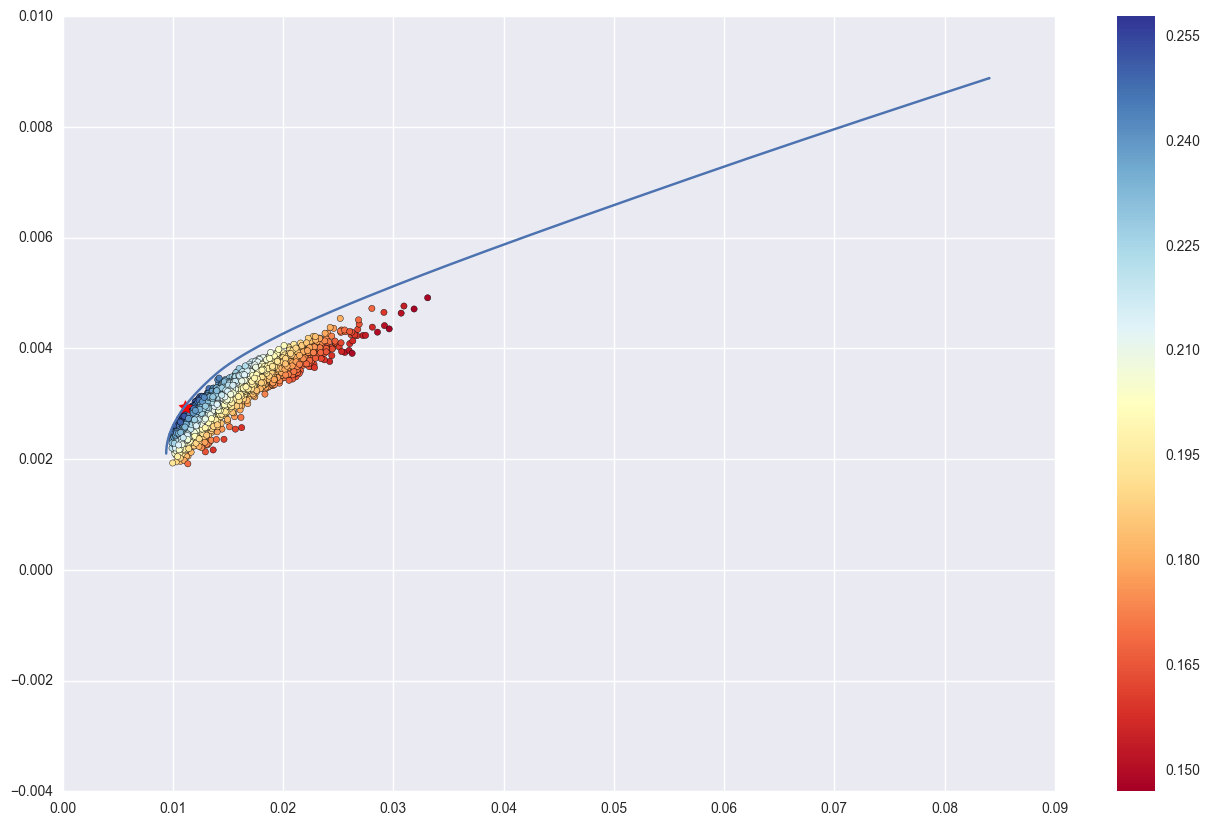

In [14]:
plt.figure(figsize=(16, 10))
results_frame = pd.DataFrame(columns=['ret','stdev','sharpe'])
results_frame['ret'] = means.T[0]
results_frame['stdev'] = stds.T[0]
results_frame['sharpe'] = results_frame['ret']/results_frame['stdev']

#create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.plot(risks, returns)
plt.colorbar()
plt.scatter(risks[idmax],returns[idmax],marker=(5,1,0),color='r',s=100)